In [23]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
bps = pd.read_csv('./all_bps_comparison_sim_tiny2.csv', header=None)

In [3]:
bps.columns = ['idx','log_sp','stdev']

In [4]:
bps.head()

,idx,log_sp,stdev
0,818,2.57653,0.304358
1,797,2.26543,0.278285
2,919,2.11920,0.258836
3,934,1.80879,0.228290
4,191,1.62827,0.204339


In [5]:
bps.shape

(240, 3)

In [6]:
ground_truth = pd.read_csv('./10nodes_40regions_10000reads_sim_tiny2_effective_regions.txt',header=None)
ground_truth = ground_truth[0].values.tolist()
ground_truth

[178, 201, 322, 545, 678, 707, 797, 861, 873, 919]

In [7]:
Counter((bps['log_sp'] - bps['stdev']).values > 0)

Counter({False: 28, True: 212})

### ROC curve
Each breakpoint candidate has a different stdev value. The ROC computations should take that into account.

In [51]:
threshold_coeffs = np.linspace(0.1,2.1,1000)

In [52]:
tpr_values = []
fpr_values = []
for thr in threshold_coeffs:
    positives = bps[(thr*(bps['log_sp']) - bps['stdev'] > 0)]['idx'].values.tolist()
    negatives = bps[(thr*(bps['log_sp']) - bps['stdev'] <= 0)]['idx'].values.tolist()

    true_positives = [i for i in positives if i in ground_truth]
    false_positives = [i for i in positives if i not in true_positives]

    true_negatives = [i for i in negatives if i not in ground_truth]
    false_negatives = [i for i in negatives if i in ground_truth]

    tpr = len(true_positives) / (len(true_positives) + len(false_negatives))
    fpr = len(false_positives) / (len(false_positives) + len(true_negatives))
    tpr_values.append(tpr)
    fpr_values.append(fpr)

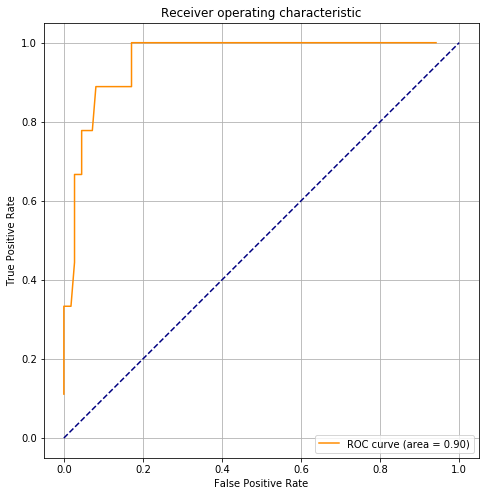

In [53]:
roc_auc = auc(fpr_values, tpr_values)
plt.figure(figsize=(8,8))
plt.plot(fpr_values, tpr_values, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()